In [44]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os

def load_data_from_folders(base_dir, activity_folders):
    column_names = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    all_data = pd.DataFrame()
    label_encoder = LabelEncoder()
    scaler = StandardScaler()
    
    # Load data from each folder
    for activity in activity_folders:
        folder_path = os.path.join(base_dir, activity)
        files = [f for f in os.listdir(folder_path) if not os.path.isdir(os.path.join(folder_path, f))]
        activity_data = pd.DataFrame()
        
        for file in files:
            file_path = os.path.join(folder_path, file)
            try:
                # Ensure data does not include any non-numeric values or unexpected strings
                temp_df = pd.read_csv(file_path, comment='#', header=None, names=column_names, on_bad_lines='skip')
                temp_df = temp_df.dropna()  # Drop any rows with NaN values
                temp_df = temp_df[~temp_df.applymap(lambda x: isinstance(x, str)).any(axis=1)]  # Remove any rows that contain strings
                temp_df['label'] = activity
                activity_data = pd.concat([activity_data, temp_df], ignore_index=True)
            except pd.errors.ParserError as e:
                print(f"Skipping file {file} due to errors: {e}")
        
        all_data = pd.concat([all_data, activity_data], ignore_index=True)

    # Encode labels
    all_data['label'] = label_encoder.fit_transform(all_data['label'])
    
    # Check for non-numeric values
    feature_columns = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    all_data[feature_columns] = all_data[feature_columns].apply(pd.to_numeric, errors='coerce')  # Coerce any remaining non-numeric entries to NaN, and then drop them
    all_data = all_data.dropna(subset=feature_columns)
    
    # Normalize features
    all_data[feature_columns] = scaler.fit_transform(all_data[feature_columns])
    
    return all_data, label_encoder.classes_




# Create sequences from the data
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    feature_columns = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    for i in range(len(data) - seq_length):
        seq = data[feature_columns].iloc[i:i + seq_length].values
        label = data['label'].iloc[i + seq_length - 1]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Parameters
base_dir = '/Users/habib/Desktop/University/Spring-2024/CS73389H/Project/activity+recognition+system+based+on+multisensor+data+fusion+arem'
activity_folders = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
seq_length = 50

# Load and preprocess data
data, classes = load_data_from_folders(base_dir, activity_folders)

# Generate sequences
sequences, labels = create_sequences(data, seq_length)

# Split data and convert to tensors
X_train_val, X_test, y_train_val, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 20% of the entire dataset for validation

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)



/var/folders/3c/c516_p2j2_xfd6ky_lxkpyhw0000gn/T/ipykernel_13937/183355160.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  temp_df = temp_df[~temp_df.applymap(lambda x: isinstance(x, str)).any(axis=1)]  # Remove any rows that contain strings
/var/folders/3c/c516_p2j2_xfd6ky_lxkpyhw0000gn/T/ipykernel_13937/183355160.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  temp_df = temp_df[~temp_df.applymap(lambda x: isinstance(x, str)).any(axis=1)]  # Remove any rows that contain strings
/var/folders/3c/c516_p2j2_xfd6ky_lxkpyhw0000gn/T/ipykernel_13937/183355160.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  temp_df = temp_df[~temp_df.applymap(lambda x: isinstance(x, str)).any(axis=1)]  # Remove any rows that contain strings
/var/folders/3c/c516_p2j2_xfd6ky_lxkpyhw0000gn/T/ipykernel_13937/183355160.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use Data

In [49]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([25023, 6, 50])
torch.Size([8342, 6, 50])
torch.Size([8342, 6, 50])


In [4]:
print(y_train.shape)

torch.Size([33365])


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob=0.5):
        super(LSTMModel, self).__init__()
        
        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        
        # LSTM Network
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initializing hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        # Initializing cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Indexing hidden state of the last time step
        out = self.fc(out[:, -1, :]) 
        return out


In [11]:
class EnhancedLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob=0.5):
        super(EnhancedLSTMModel, self).__init__()
        
        # Define the number of layers and nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=True)
        
        # Fully connected layer
        self.fc1 = nn.Linear(hidden_dim*2, 128)  # Multiply by 2 for bidirectional LSTM
        self.fc2 = nn.Linear(128, output_dim)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).requires_grad_().to(x.device)
        
        # Initialize cell state
        c0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).requires_grad_().to(x.device)
        
        # LSTM
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Fully connected layers
        out = self.dropout(F.relu(self.fc1(out[:, -1, :])))  # Take only the last time step
        out = self.fc2(out)
        return out


In [53]:
def train_model(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

def validate_model(model, val_loader, criterion):
    model.eval()
    total = 0
    correct = 0
    all_predicted = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predicted.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    
    val_loss = criterion(outputs, labels)
    accuracy = 100 * correct / total
    return val_loss, accuracy, all_labels, all_predicted


In [39]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        val_loss, val_accuracy = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    
    return train_losses, val_losses, val_accuracies

def validate_model(model, data_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(data_loader)
    accuracy = 100 * correct / total
    return val_loss, accuracy

# Assuming model, train_loader, val_loader, criterion, optimizer, and num_epochs are already defined

train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Calculate test accuracy
test_loss, test_accuracy = validate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch 1/5, Train Loss: 0.6906, Val Loss: 0.4993, Val Acc: 80.14%
Epoch 2/5, Train Loss: 0.4080, Val Loss: 0.4068, Val Acc: 83.25%
Epoch 3/5, Train Loss: 0.3548, Val Loss: 0.2874, Val Acc: 88.14%
Epoch 4/5, Train Loss: 0.2870, Val Loss: 0.2723, Val Acc: 89.02%
Epoch 5/5, Train Loss: 0.2584, Val Loss: 0.2606, Val Acc: 89.32%
Test Loss: 0.2609, Test Accuracy: 88.83%


In [14]:
class CNNModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * (input_length // 8), 256)  # input_length should be defined
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * (input_length // 8))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [16]:
def train(model, train_loader, val_loader, optimizer, criterion, num_epochs):
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        val_loss, val_accuracy = validate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    
    return train_losses, val_losses, val_accuracies

def validate(model, data_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(data_loader)
    accuracy = 100 * correct / total
    return val_loss, accuracy


In [50]:
# Swap channel and time dimensions for compatibility with PyTorch Conv1D
X_train = X_train.permute(0, 2, 1)
X_val = X_val.permute(0, 2, 1)
X_test = X_test.permute(0, 2, 1)

In [51]:
# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, input_channels, num_classes, seq_length):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * (seq_length // 8), 256)  # Adjust input size based on sequence length
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * (seq_length // 8))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define train function
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        val_loss, val_accuracy = validate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    
    return train_losses, val_losses, val_accuracies

# Define validation function
def validate(model, data_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(data_loader)
    accuracy = 100 * correct / total
    return val_loss, accuracy

# Define your dataset, dataloaders, hyperparameters, etc.

# Assuming you have defined train_loader, val_loader, test_loader, input_channels, num_classes, seq_length, etc.

# Define hyperparameters
learning_rate = 0.001
num_epochs = 10

# Create model instance
model = CNNModel(input_channels, num_classes, seq_length)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses, val_losses, val_accuracies = train(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Evaluate on the test set
test_loss, test_accuracy = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch 1/10, Train Loss: 0.3976, Val Loss: 0.2486, Val Acc: 89.75%
Epoch 2/10, Train Loss: 0.2276, Val Loss: 0.2129, Val Acc: 90.58%
Epoch 3/10, Train Loss: 0.1862, Val Loss: 0.1502, Val Acc: 93.56%
Epoch 4/10, Train Loss: 0.1329, Val Loss: 0.1052, Val Acc: 95.73%
Epoch 5/10, Train Loss: 0.1084, Val Loss: 0.1108, Val Acc: 95.59%
Epoch 6/10, Train Loss: 0.0774, Val Loss: 0.0715, Val Acc: 97.23%
Epoch 7/10, Train Loss: 0.0527, Val Loss: 0.0322, Val Acc: 99.11%
Epoch 8/10, Train Loss: 0.0473, Val Loss: 0.0360, Val Acc: 98.67%
Epoch 9/10, Train Loss: 0.0522, Val Loss: 0.0299, Val Acc: 99.06%
Epoch 10/10, Train Loss: 0.0173, Val Loss: 0.0324, Val Acc: 98.68%
Test Loss: 0.0272, Test Accuracy: 99.05%


In [54]:
# Model parameters
input_dim = 6  # Number of features
hidden_dim = 100  # Number of hidden nodes
layer_dim = 1  # Number of LSTM layers
output_dim = len(classes)  # Number of outputs
learning_rate = 0.001

# Initialize model, loss, and optimizer
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, criterion, optimizer)
    val_loss, val_accuracy, all_labels, all_predicted = validate_model(model, val_loader, criterion)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}, Accuracy: {val_accuracy}%')

# After training
conf_matrix = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:")
print(conf_matrix)


Epoch 1/5, Training Loss: 0.6144033264168693, Validation Loss: 0.51658034324646, Accuracy: 84.47614480939822%
Epoch 2/5, Training Loss: 0.41281994796165117, Validation Loss: 0.6221436262130737, Accuracy: 84.40421961160393%
Epoch 3/5, Training Loss: 0.35850544978895454, Validation Loss: 0.42149588465690613, Accuracy: 86.3701750179813%
Epoch 4/5, Training Loss: 0.32025419236601466, Validation Loss: 0.495313823223114, Accuracy: 89.11532006713018%
Epoch 5/5, Training Loss: 0.2689504167422309, Validation Loss: 0.4167671501636505, Accuracy: 90.51786142411892%
Confusion Matrix:
[[ 627    2    0    0   64    0    0]
 [  23  405    1    1   33    0    2]
 [   0    4 1442    0    0    0   11]
 [   0   11    2 1393   13   16    0]
 [  31    3    0   47  957  372    0]
 [   0    0    0   10  141 1321    0]
 [   0    0    4    0    0    0 1406]]


In [55]:
test_loss, test_accuracy, test_labels, test_predictions = validate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}%')

Test Loss: 0.11098288744688034, Test Accuracy: 89.84655957803884%


In [56]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, test_predictions, target_names=classes))


              precision    recall  f1-score   support

    bending1       0.93      0.91      0.92       704
    bending2       0.94      0.86      0.90       483
     cycling       1.00      0.99      0.99      1467
       lying       0.94      0.97      0.96      1381
     sitting       0.79      0.66      0.72      1478
    standing       0.75      0.88      0.81      1401
     walking       0.99      0.99      0.99      1428

    accuracy                           0.90      8342
   macro avg       0.91      0.90      0.90      8342
weighted avg       0.90      0.90      0.90      8342



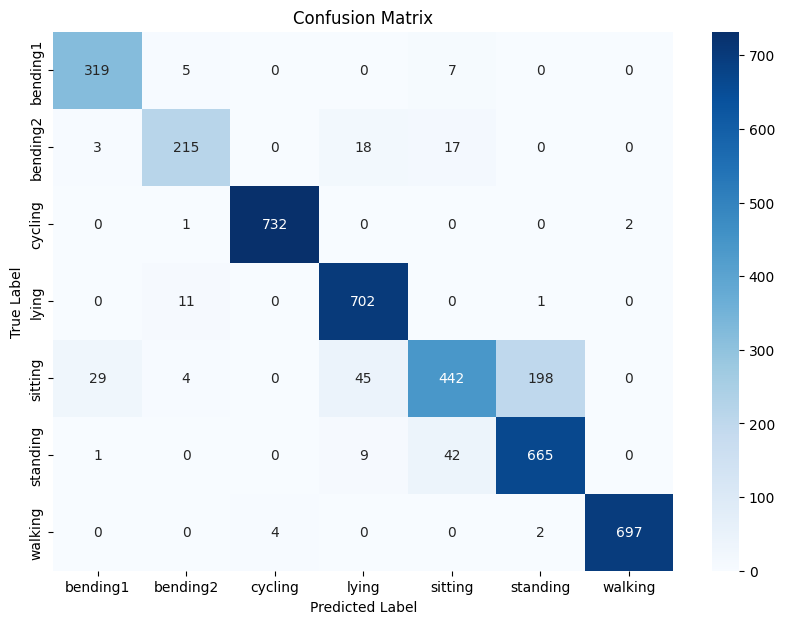

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(conf_matrix, classes):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Assuming 'classes' variable holds class names from LabelEncoder
plot_confusion_matrix(conf_matrix, classes)
